# Sparkify Project - Predicting churn rates
This project aims to predict churn rates of Sparkify users. The smaller subset (128MB) of the full dataset (12GB) is explored before deploying on the cloud.

The analysis includes four sections:
1. Load and Clean Dataset
2. Exploratory Data Analysis
3. Feature Engineering
4. Modelling and Evaluation

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, asc, sum, min, max, split, udf,to_date \
                                , concat_ws,first,last,countDistinct,when,count,datediff,trim,split\
                                , element_at ,row_number
from pyspark.sql.types import StringType,IntegerType,DoubleType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier,LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer,VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics

import re

import datetime
import time

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Analysis") \
    .getOrCreate()

# Load and Clean Dataset
Load and clean the small dataset file `mini_sparkify_event_data.json` first before deploying to the Spark Cluster.

In [4]:
#read json data
data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
#look at the first record
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [4]:
#print schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
#check missing values for each column
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).collect()

[Row(artist=58392, auth=0, firstName=8346, gender=8346, itemInSession=0, lastName=8346, length=58392, level=0, location=8346, method=0, page=0, registration=8346, sessionId=0, song=58392, status=0, ts=0, userAgent=8346, userId=0)]

In [10]:
#check blank user ID
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [7]:
#explore users with missing user id
df.filter(df.userId == "").groupby('auth').count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



In [5]:
#check blank session ID
df.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [4]:
#check data size
df.count()

286500

In [5]:
#exclude users with blank user id because they are mainly logged out users or Guest, which means no churn info.
df_valid = df.filter(df["userId"] != "")

In [11]:
#check data size again
df_valid.count()

278154

# Exploratory Data Analysis
Even when working with the full dataset, we should perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this step, I will explore the small subset of data first.

### Define Churn
I use the `Cancellation Confirmation` events to define churn, which happen for both paid and free users. Among 225 users in this small dataset, 52 users submit the cancellation confirmation. 

In [17]:
# page events
df_valid.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [16]:
#total users
df_valid.select(col('userId')).dropDuplicates().count()

225

In [8]:
#churn users
df_valid.filter(df.page == "Cancellation Confirmation").groupby('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|   21|
| paid|   31|
+-----+-----+



In [18]:
#flag Cancellation Confirmation event
flag_cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_valid = df_valid.withColumn("Cancellation", flag_cancel_event("page"))
df_valid.filter(df_valid.page =='Cancellation Confirmation').head()

Row(artist=None, auth='Cancelled', firstName='Adriel', gender='M', itemInSession=104, lastName='Mendoza', length=None, level='paid', location='Kansas City, MO-KS', method='GET', page='Cancellation Confirmation', registration=1535623466000, sessionId=514, song=None, status=200, ts=1538943990000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='18', Cancellation=1)

In [19]:
#define Churn users
windowval = Window.partitionBy("userId")
df_valid = df_valid.withColumn("Churn", max("Cancellation").over(windowval))

In [10]:
#check user example
df_valid.select(["userId", "firstname", "ts", "page", "Cancellation", "Churn"])\
.where(df_valid.userId == "18").sort("ts").collect()

[Row(userId='18', firstname='Adriel', ts=1538499917000, page='Home', Cancellation=0, Churn=1),
 Row(userId='18', firstname='Adriel', ts=1538499933000, page='NextSong', Cancellation=0, Churn=1),
 Row(userId='18', firstname='Adriel', ts=1538500208000, page='NextSong', Cancellation=0, Churn=1),
 Row(userId='18', firstname='Adriel', ts=1538500476000, page='NextSong', Cancellation=0, Churn=1),
 Row(userId='18', firstname='Adriel', ts=1538500654000, page='NextSong', Cancellation=0, Churn=1),
 Row(userId='18', firstname='Adriel', ts=1538500842000, page='NextSong', Cancellation=0, Churn=1),
 Row(userId='18', firstname='Adriel', ts=1538500856000, page='Settings', Cancellation=0, Churn=1),
 Row(userId='18', firstname='Adriel', ts=1538501009000, page='NextSong', Cancellation=0, Churn=1),
 Row(userId='18', firstname='Adriel', ts=1538501340000, page='NextSong', Cancellation=0, Churn=1),
 Row(userId='18', firstname='Adriel', ts=1538501587000, page='NextSong', Cancellation=0, Churn=1),
 Row(userId='1

### Explore Data
Then perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned using Spark SQL.

In [153]:
#create temperate view for all data
df_valid.createOrReplaceTempView("df_valid")

In [26]:
#group size in mini data
spark.sql("SELECT Churn, COUNT(DISTINCT userID) \
            FROM df_valid \
            group by Churn").show()

+-----+----------------------+
|Churn|count(DISTINCT userID)|
+-----+----------------------+
|    1|                    52|
|    0|                   173|
+-----+----------------------+



In [14]:
#create temperate view for group size
spark.sql("SELECT Churn, COUNT(DISTINCT userID) as total_mem \
            FROM df_valid \
            group by Churn").createOrReplaceTempView("size")

In [41]:
#gender explore
spark.sql("SELECT a.Churn, gender, COUNT(DISTINCT userID) as mem \
           , COUNT(DISTINCT userID)/total_mem as percent\
            FROM df_valid as a join size on a.churn = size.churn\
            group by a.Churn,gender,total_mem \
            order by 1,2").show()
#62% of Users who churned are males.

+-----+------+---+-------------------+
|Churn|gender|mem|            percent|
+-----+------+---+-------------------+
|    0|     F| 84|0.48554913294797686|
|    0|     M| 89| 0.5144508670520231|
|    1|     F| 20|0.38461538461538464|
|    1|     M| 32| 0.6153846153846154|
+-----+------+---+-------------------+



In [55]:
#action explore
spark.sql("select nvl(a.page, b.page) as page \
          , a.churn_mem, churn_percent \
          , b.not_churn_mem, not_churn_percent from \
           (SELECT page, COUNT(DISTINCT userID) churn_mem \
            , COUNT(DISTINCT userID)/total_mem as churn_percent\
            FROM df_valid as c join size on c.churn = size.churn\
            where c.Churn =1 \
            group by page,total_mem) a\
            full join \
           (SELECT page,COUNT(DISTINCT userID) not_churn_mem \
           , COUNT(DISTINCT userID)/total_mem as not_churn_percent\
            FROM df_valid as nc join size on nc.churn = size.churn\
            where nc.Churn =0 \
            group by page,total_mem) b\
            on a.page = b.page \
            order by 2 desc \
            ").show()
#Users who churned have higher % in action: Roll Advert, Thumbs Down 
#and lower % in action: Thumbs Up, Add Friend, Upgrade, Error,Help

+--------------------+---------+-------------------+-------------+-------------------+
|                page|churn_mem|      churn_percent|not_churn_mem|  not_churn_percent|
+--------------------+---------+-------------------+-------------+-------------------+
|            NextSong|       52|                1.0|          173|                1.0|
|              Cancel|       52|                1.0|         null|               null|
|Cancellation Conf...|       52|                1.0|         null|               null|
|                Home|       51| 0.9807692307692307|          172| 0.9942196531791907|
|     Add to Playlist|       50| 0.9615384615384616|          165|  0.953757225433526|
|         Roll Advert|       50| 0.9615384615384616|          157| 0.9075144508670521|
|           Thumbs Up|       50| 0.9615384615384616|          170| 0.9826589595375722|
|         Thumbs Down|       48| 0.9230769230769231|          155| 0.8959537572254336|
|              Logout|       46| 0.88461538

In [56]:
#artist explore
spark.sql("select nvl(a.artist, b.artist) as artist \
          , a.churn_mem, churn_percent \
          , b.not_churn_mem, not_churn_percent from \
           (SELECT artist, COUNT(DISTINCT userID) churn_mem \
            , COUNT(DISTINCT userID)/total_mem as churn_percent\
            FROM df_valid as c join size on c.churn = size.churn\
            where c.Churn =1 \
            group by artist,total_mem) a\
            full join \
           (SELECT artist,COUNT(DISTINCT userID) not_churn_mem \
           , COUNT(DISTINCT userID)/total_mem as not_churn_percent\
            FROM df_valid as nc join size on nc.churn = size.churn\
            where nc.Churn =0 \
            group by artist,total_mem) b\
            on a.artist = b.artist \
            order by 2 desc \
            ").show()
#Users who churned have lower % in top 20 artists

+--------------------+---------+------------------+-------------+------------------+
|              artist|churn_mem|     churn_percent|not_churn_mem| not_churn_percent|
+--------------------+---------+------------------+-------------+------------------+
|                null|       52|               1.0|         null|              null|
|Florence + The Ma...|       43|0.8269230769230769|          144|0.8323699421965318|
|       Kings Of Leon|       42|0.8076923076923077|          157|0.9075144508670521|
|       Dwight Yoakam|       41|0.7884615384615384|          148|0.8554913294797688|
|            Coldplay|       40|0.7692307692307693|          149| 0.861271676300578|
|            BjÃÂ¶rk|       39|              0.75|          140|0.8092485549132948|
|      The Black Keys|       38|0.7307692307692307|          141| 0.815028901734104|
|       Guns N' Roses|       37|0.7115384615384616|          133|0.7687861271676301|
|       Justin Bieber|       37|0.7115384615384616|          140|

In [57]:
#song explore
spark.sql("select nvl(a.song, b.song) as song \
          , a.churn_mem, churn_percent \
          , b.not_churn_mem, not_churn_percent from \
           (SELECT song, COUNT(DISTINCT userID) churn_mem \
            , COUNT(DISTINCT userID)/total_mem as churn_percent\
            FROM df_valid as c join size on c.churn = size.churn\
            where c.Churn =1 \
            group by song,total_mem) a\
            full join \
           (SELECT song,COUNT(DISTINCT userID) not_churn_mem \
           , COUNT(DISTINCT userID)/total_mem as not_churn_percent\
            FROM df_valid as nc join size on nc.churn = size.churn\
            where nc.Churn =0 \
            group by song,total_mem) b\
            on a.song = b.song\
            order by 2 desc \
            ").show()
#Users who churned have lower % in top 20 songs

+--------------------+---------+-------------------+-------------+------------------+
|                song|churn_mem|      churn_percent|not_churn_mem| not_churn_percent|
+--------------------+---------+-------------------+-------------+------------------+
|                null|       52|                1.0|         null|              null|
|      You're The One|       41| 0.7884615384615384|          149| 0.861271676300578|
|             Revelry|       40| 0.7692307692307693|          137| 0.791907514450867|
|                Undo|       39|               0.75|          137| 0.791907514450867|
|Horn Concerto No....|       36| 0.6923076923076923|          128|0.7398843930635838|
|Dog Days Are Over...|       36| 0.6923076923076923|          126|0.7283236994219653|
|       Sehr kosmisch|       34| 0.6538461538461539|          138|0.7976878612716763|
|              Canada|       32| 0.6153846153846154|          108|0.6242774566473989|
|        Use Somebody|       29| 0.5576923076923077|  

In [31]:
#location explore
spark.sql("select nvl(a.location, b.location) as location \
          , a.churn_mem, churn_percent \
          , b.not_churn_mem, not_churn_percent from \
           (SELECT location, COUNT(DISTINCT userID) churn_mem \
            , COUNT(DISTINCT userID)/total_mem as churn_percent\
            FROM df_valid as c join size on c.churn = size.churn\
            where c.Churn =1 \
            group by location,total_mem) a\
            full join \
           (SELECT location,COUNT(DISTINCT userID) not_churn_mem \
           , COUNT(DISTINCT userID)/total_mem as not_churn_percent\
            FROM df_valid as nc join size on nc.churn = size.churn\
            where nc.Churn =0 \
            group by location,total_mem) b\
            on a.location = b.location\
            order by 2 desc \
            ").show()
# location data seems very sparse

+--------------------+---------+--------------------+-------------+--------------------+
|            location|churn_mem|       churn_percent|not_churn_mem|   not_churn_percent|
+--------------------+---------+--------------------+-------------+--------------------+
|New York-Newark-J...|        5| 0.09615384615384616|           10|0.057803468208092484|
|Los Angeles-Long ...|        3|0.057692307692307696|           13| 0.07514450867052024|
|Miami-Fort Lauder...|        2|0.038461538461538464|            3|0.017341040462427744|
|Spokane-Spokane V...|        2|0.038461538461538464|         null|                null|
|         Jackson, MS|        2|0.038461538461538464|         null|                null|
|Phoenix-Mesa-Scot...|        2|0.038461538461538464|            5|0.028901734104046242|
|Philadelphia-Camd...|        2|0.038461538461538464|            3|0.017341040462427744|
|           Flint, MI|        2|0.038461538461538464|         null|                null|
|Birmingham-Hoover...

In [45]:
#state explore
spark.sql("select nvl(a.state, b.state) as state\
          , a.churn_mem, churn_percent \
          , b.not_churn_mem, not_churn_percent from \
           (SELECT right(location,2) as state, COUNT(DISTINCT userID) churn_mem \
            , COUNT(DISTINCT userID)/total_mem as churn_percent\
            FROM df_valid as c join size on c.churn = size.churn\
            where c.Churn =1 \
            group by state,total_mem) a\
            full join \
           (SELECT right(location,2) as state,COUNT(DISTINCT userID) not_churn_mem \
           , COUNT(DISTINCT userID)/total_mem as not_churn_percent\
            FROM df_valid as nc join size on nc.churn = size.churn\
            where nc.Churn =0 \
            group by state,total_mem) b\
            on a.state = b.state\
            order by 2 desc \
            ").show()
# States data is also very sparse, CA have relatively more users 

+-----+---------+--------------------+-------------+--------------------+
|state|churn_mem|       churn_percent|not_churn_mem|   not_churn_percent|
+-----+---------+--------------------+-------------+--------------------+
|   CA|        6| 0.11538461538461539|           27| 0.15606936416184972|
|   PA|        5| 0.09615384615384616|           13| 0.07514450867052024|
|   MD|        3|0.057692307692307696|            4|0.023121387283236993|
|   MI|        3|0.057692307692307696|            2|0.011560693641618497|
|   TX|        3|0.057692307692307696|           13| 0.07514450867052024|
|   FL|        3|0.057692307692307696|           11| 0.06358381502890173|
|   CO|        2|0.038461538461538464|            2|0.011560693641618497|
|   MS|        2|0.038461538461538464|            1|0.005780346820809248|
|   AZ|        2|0.038461538461538464|            5|0.028901734104046242|
|   AL|        2|0.038461538461538464|            4|0.023121387283236993|
|   WA|        2|0.038461538461538464|

In [19]:
#avg artists/songs by user
spark.sql("select churn,count(distinct artist)/count(distinct userid) avg_artists, \
           count(distinct song)/count(distinct userid) avg_songs, \
           count(distinct location)/count(distinct userid) avg_locations, \
           count(distinct right(location,2))/count(distinct userid) avg_states \
           from df_valid \
           group by churn \
          ").show()
#Users who churned heard more artists/songs and switched more locations?? maybe different enroll length?

+-----+------------------+------------------+------------------+-------------------+
|churn|       avg_artists|         avg_songs|     avg_locations|         avg_states|
+-----+------------------+------------------+------------------+-------------------+
|    1|161.57692307692307|369.53846153846155|0.7692307692307693|                0.5|
|    0| 96.25433526011561| 308.3005780346821|0.5433526011560693|0.20809248554913296|
+-----+------------------+------------------+------------------+-------------------+



In [20]:
#add date time
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).year)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_valid = df_valid.withColumn("year",get_year("ts"))
df_valid = df_valid.withColumn("month",get_month("ts"))
df_valid = df_valid.withColumn("day",get_day("ts"))
df_valid = df_valid.withColumn("hour",get_hour("ts"))
df_valid = df_valid.withColumn("date", to_date(concat_ws("-", "year", "month", "day")))

In [21]:
#check user example
df_valid.filter(df_valid.userId=='100010').sort("ts").collect()

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Cancellation=0, Churn=0, year='2018', month='10', day='8', hour='12', date=datetime.date(2018, 10, 8)),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=200, ts=1539003736000, userAgent='"Mozilla/5.0 (i

In [24]:
#recreate view for all data
df_valid.createOrReplaceTempView("df_valid")

In [25]:
#create temperate view for enroll length
spark.sql("select churn,userid,datediff(max(date),min(date)) enroll_days \
           ,count(distinct date) active_days \
           from df_valid \
           group by churn,userid \
          ").createOrReplaceTempView("enroll_length")

In [27]:
#avg enroll days, active days, active ratio by churn group
spark.sql("select churn, avg(enroll_days),avg(active_days),avg(active_days/enroll_days) as avg_active_ratio \
          from enroll_length \
          group by churn \
          ").show()
#Users who churned have fewer avg enroll_days and active days but higher active_ratio

+-----+-----------------+------------------+------------------+
|churn| avg(enroll_days)|  avg(active_days)|  avg_active_ratio|
+-----+-----------------+------------------+------------------+
|    1|23.46153846153846| 9.826923076923077| 0.567671094359117|
|    0|46.93063583815029|15.104046242774567|0.3200569146027875|
+-----+-----------------+------------------+------------------+



In [68]:
#avg artists/songs/locations by user and enroll length
spark.sql("select churn,\
           round(count(distinct artist)/sum(enroll_days),4) artists_per_enrollday, \
           round(count(distinct song)/sum(enroll_days),4) songs_per_enrollday, \
           round(count(distinct location)/sum(enroll_days),6) locations_per_enrollday, \
           round(count(distinct artist)/sum(active_days),4) artists_per_activeday, \
           round(count(distinct song)/sum(active_days),4) songs_per_activeday, \
           round(count(distinct location)/sum(active_days),6) locations_per_activeday \
           from df_valid a join enroll_length b on a.userid = b.userid \
           group by churn \
          ").show()
#Users who churned still heard more artists/songs and switched more locations per enrolled day or active day

+-----+---------------------+-------------------+-----------------------+---------------------+-------------------+-----------------------+
|churn|artists_per_enrollday|songs_per_enrollday|locations_per_enrollday|artists_per_activeday|songs_per_activeday|locations_per_activeday|
+-----+---------------------+-------------------+-----------------------+---------------------+-------------------+-----------------------+
|    1|               0.0059|             0.0135|                 2.8E-5|               0.0117|             0.0267|                 5.6E-5|
|    0|               0.0013|             0.0041|                 7.0E-6|               0.0027|             0.0086|                 1.5E-5|
+-----+---------------------+-------------------+-----------------------+---------------------+-------------------+-----------------------+



In [37]:
#avg song length and songs played hour explore
spark.sql("select churn, \
           avg(length) avg_song_length, \
           avg(hour) avg_hour_per_day \
           from df_valid \
           where page='NextSong' \
           group by churn \
          ").show()
#no big difference

+-----+------------------+------------------+
|churn|   avg_song_length|  avg_hour_per_day|
+-----+------------------+------------------+
|    1|248.63279564406218|12.318129361982745|
|    0|249.20913538880816|12.169346004986595|
+-----+------------------+------------------+



In [52]:
#One day might contain multiple sessions
spark.sql("select userid,date,count(distinct sessionId) session \
           from df_valid \
           group by userid,date \
           having count(distinct sessionId) >1 \
           order by 2 desc \
          ").show()

+------+----------+-------+
|userid|      date|session|
+------+----------+-------+
|    85|2018-11-30|      2|
|   112|2018-11-30|      2|
|300018|2018-11-30|      2|
|   140|2018-11-30|      2|
|    39|2018-11-30|      2|
|    92|2018-11-30|      3|
|200023|2018-11-30|      2|
|300021|2018-11-30|      2|
|300011|2018-11-30|      3|
|300025|2018-11-29|      2|
|    92|2018-11-29|      4|
|200003|2018-11-29|      3|
|    85|2018-11-29|      2|
|    39|2018-11-29|      2|
|300017|2018-11-29|      2|
|   136|2018-11-29|      2|
|300015|2018-11-29|      2|
|    25|2018-11-28|      2|
|    82|2018-11-28|      2|
|100004|2018-11-28|      2|
+------+----------+-------+
only showing top 20 rows



In [64]:
#check top user
df_valid.filter((df_valid.userId=='85') & (df_valid.date == '2018-11-30')).sort("ts").collect()

[Row(artist='Eddie Izzard', auth='Logged In', firstName='Brayden', gender='M', itemInSession=32, lastName='Thomas', length=606.74567, level='paid', location='Los Angeles-Long Beach-Anaheim, CA', method='PUT', page='NextSong', registration=1534133898000, sessionId=2431, song='Horror Movies', status=200, ts=1543536082000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='85', Cancellation=0, Churn=0, year='2018', month='11', day='30', hour='0', date=datetime.date(2018, 11, 30)),
 Row(artist='Leon Russell', auth='Logged In', firstName='Brayden', gender='M', itemInSession=33, lastName='Thomas', length=185.73016, level='paid', location='Los Angeles-Long Beach-Anaheim, CA', method='PUT', page='NextSong', registration=1534133898000, sessionId=2431, song='Act Naturally (Album Version)', status=200, ts=1543536688000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, 

In [80]:
#distinct sessions, item in sessions, page per user example
spark.sql("select churn, count(distinct sessionid)/count(distinct userid) sessions_per_user \
          ,count(distinct itemInSession)/count(distinct userid) items_per_user \
          ,count(distinct page)/count(distinct userid) pages_per_user\
          ,count(distinct itemInSession)/count(distinct sessionid) items_per_session \
          ,count(distinct page)/count(distinct sessionid) pages_per_session \
          from df_valid \
          where userid ='85' and date ='2018-11-30' \
          group by churn \
          ").show()

+-----+-----------------+--------------+--------------+-----------------+-----------------+
|churn|sessions_per_user|items_per_user|pages_per_user|items_per_session|pages_per_session|
+-----+-----------------+--------------+--------------+-----------------+-----------------+
|    0|              2.0|         137.0|          11.0|             68.5|              5.5|
+-----+-----------------+--------------+--------------+-----------------+-----------------+



In [82]:
#distinct sessions, item in sessions, page per user
spark.sql("select churn, count(distinct sessionid)/count(distinct userid) sessions_per_user \
          ,count(distinct itemInSession)/count(distinct userid) items_per_user \
          ,count(distinct page)/count(distinct userid) pages_per_user\
          ,count(distinct itemInSession)/count(distinct sessionid) items_per_session \
          ,count(distinct page)/count(distinct sessionid) pages_per_session \
          from df_valid \
          where Cancellation=0 \
          group by churn \
          ").show()
#Users who churned have fewer average sessions, more items in sessions and more distinct pages \
#(exclude Cancellation)

+-----+------------------+-----------------+-------------------+------------------+--------------------+
|churn| sessions_per_user|   items_per_user|     pages_per_user| items_per_session|   pages_per_session|
+-----+------------------+-----------------+-------------------+------------------+--------------------+
|    1|               9.0|17.03846153846154|0.34615384615384615| 1.893162393162393|0.038461538461538464|
|    0|12.196531791907514|7.578034682080925|0.09826589595375723|0.6213270142180095|0.008056872037914692|
+-----+------------------+-----------------+-------------------+------------------+--------------------+



In [28]:
#distinct sessions, item in sessions, page per user per day
spark.sql("select churn, avg(sessions) avg_sessions,avg(items) avg_items,avg(pages) avg_pages \
          from (select churn,userid,date, count(distinct sessionid) sessions \
          ,count(itemInSession) items \
          ,count(distinct page) pages\
          from df_valid \
          where Cancellation=0 \
          group by churn,userid,date ) a\
          group by churn \
          ").show()
#Users who churned have similar average sessions, fewer items in sessions and more distinct pages per day \
#(exclude Cancellation)

+-----+------------------+-----------------+-----------------+
|churn|      avg_sessions|        avg_items|        avg_pages|
+-----+------------------+-----------------+-----------------+
|    1|1.2627450980392156|87.86666666666666|6.974509803921569|
|    0|1.2139303482587065|89.28052047455033|6.571373899732109|
+-----+------------------+-----------------+-----------------+



# Feature Engineering
Build out those 18 features on the small dataset first and then transfer over the features to the larger dataset on Spark cluster.

### Extract Potential Features 
- gender: female(1) or male(0)
- main state ratio: State with highest frequency / Count of total states
- distinct locations: Count of distinct locations
- distinct page actions: Count of distinct pages
- page action ratios
    - tbup_ratio: Count of Thumbs Up events / Count of total pages
    - tbdw_ratio: Count of Thumbs Down events / Count of total pages
    - addfriend_ratio: Count of Add Friend events / Count of total pages
    - ad_ratio: Count of Roll Advert events / Count of total pages
    - up_ratio: Count of Upgrade events / Count of total pages
    - help_ratio: Count of Help events / Count of total pages
    - error_ratio: Count of Error events / Count of total pages
    
- enroll days: max date - min date +1
- active days: Count of distinct dates
- active ratio: active days / enroll days
- distinct artists per active day: Count of distinct artists / active days  
- distinct songs per active day: Count of distinct songs / active days  
- avg songs per active day: Count of total songs / active days   
- avg items per session: Count of total items / Count of distinct sessions  

In [29]:
# main state (highest frequency)
df_valid = df_valid.withColumn("state", trim(element_at(split(col("location"), ","),-1)))
state_cnt = df_valid.groupBy("userId", "state").count()

w = Window().partitionBy("userId").orderBy(col("count").desc())

main_state = (state_cnt
  .withColumn("rn", row_number().over(w))
  .where(col("rn") == 1)
  .select("userId", col("state").alias('main_state')))

In [30]:
# Adding main state feature to df_valid
df_valid = df_valid.join(main_state, on = 'userId')

In [17]:
#check state values
df_valid.groupby('main_state').agg(countDistinct(col('userid')).alias('ct')).sort(desc('ct')).show()

+-----------+---+
| main_state| ct|
+-----------+---+
|         CA| 33|
|         TX| 16|
|   NY-NJ-PA| 15|
|         FL| 14|
|         CT|  7|
|         AZ|  7|
|   IL-IN-WI|  6|
|      MO-IL|  6|
|         NC|  6|
|      NC-SC|  6|
|PA-NJ-DE-MD|  5|
|      MA-NH|  5|
|         NY|  5|
|         MI|  5|
|         GA|  4|
|         WA|  4|
|         CO|  4|
|DC-VA-MD-WV|  4|
|         AL|  4|
|         IL|  3|
+-----------+---+
only showing top 20 rows



In [31]:
# Extract potential features 
df_user = df_valid.groupby('userId').agg(
     # target
     first(col('Churn')).alias('label'),
     # gender
     first(when(col('gender') == "F", 1).otherwise(0)).alias('female'),
     # #main state ratio
     ((sum(when(col('state') == col('main_state'), 1).otherwise(0)))/count(col('state'))).alias("mstate_ratio"),
     # distinct locations
     countDistinct(col('location')).alias('ulocation_ct'),
     # distinct page actions
     countDistinct(col('page')).alias('upage_ct'),
     # page action ratio
    ((sum(when(col('page') == "Thumbs Up", 1).otherwise(0)))/count(col('page'))).alias("tbup_ratio"),
    ((sum(when(col('page') == "Thumbs Down", 1).otherwise(0)))/count(col('page'))).alias("tbdw_ratio"),
    ((sum(when(col('page') == "Add Friend", 1).otherwise(0)))/count(col('page'))).alias("addfriend_ratio"),   
    ((sum(when(col('page') == "Roll Advert", 1).otherwise(0)))/count(col('page'))).alias("ad_ratio"),
    ((sum(when(col('page') == "Upgrade", 1).otherwise(0)))/count(col('page'))).alias("up_ratio"),
    ((sum(when(col('page') == "Help", 1).otherwise(0)))/count(col('page'))).alias("help_ratio"),
    ((sum(when(col('page') == "Error", 1).otherwise(0)))/count(col('page'))).alias("error_ratio"),
     # enroll days
     (datediff(max(col('date')),min(col('date'))) +1).alias("enroll_days"),
     # active days
     countDistinct(col('date')).alias('active_days'),
     # active ratio
     (countDistinct(col('date'))/(datediff(max(col('date')),min(col('date'))) +1)).alias('active_ratio'),
     # distinct artists per active day 
     (countDistinct(col('artist'))/countDistinct(col('date'))).alias('uartist_pact'),
     # distinct songs per active day
     (countDistinct(col('song'))/countDistinct(col('date'))).alias('usong_pact'),
     # avg songs per active day 
     (sum(when(col('page') == "NextSong",1).otherwise(0))/countDistinct(col('date'))).alias("tsong_pact"),
     # avg items per session
     (count(col('itemInSession'))/countDistinct(col('sessionId'))).alias("item_pses"))

In [38]:
#check user example
df_valid.groupby('userId').count().sort("count").head(5)

[Row(userId='156', count=6),
 Row(userId='135', count=6),
 Row(userId='125', count=11),
 Row(userId='100011', count=23),
 Row(userId='300003', count=35)]

In [20]:
#check user example
df_valid.filter(df_valid.userId=='156').collect()

[Row(userId='156', artist=None, auth='Logged In', firstName='Landon', gender='M', itemInSession=9, lastName='Cabrera', length=None, level='free', location='Scranton--Wilkes-Barre--Hazleton, PA', method='GET', page='Home', registration=1543247354000, sessionId=2288, song=None, status=200, ts=1543274040000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', Cancellation=0, Churn=0, year='2018', month='11', day='26', hour='23', date=datetime.date(2018, 11, 26), state='PA', main_state='PA'),
 Row(userId='156', artist='Vampire Weekend', auth='Logged In', firstName='Landon', gender='M', itemInSession=10, lastName='Cabrera', length=221.64853, level='free', location='Scranton--Wilkes-Barre--Hazleton, PA', method='PUT', page='NextSong', registration=1543247354000, sessionId=2288, song='Walcott (Album)', status=200, ts=1543274042000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chr

In [13]:
#check user example
df_user.filter(df_user.userId=='156').collect()

[Row(userId='156', label=0, female=0, mstate_ratio=1.0, ulocation_ct=1, upage_ct=4, tbup_ratio=0.0, tbdw_ratio=0.0, addfriend_ratio=0.0, ad_ratio=0.16666666666666666, up_ratio=0.0, help_ratio=0.0, error_ratio=0.0, enroll_days=1, active_days=1, active_ratio=1.0, uartist_pact=3.0, usong_pact=3.0, tsong_pact=3.0, item_pses=6.0)]

### Features Visualization
Then create some visualization on those new features using PySpark.

In [35]:
#convert a Spark Df to pandas DF
pandas_df = df_user.toPandas()

#### Target measure

In [31]:
#target measure counts
pandas_df.label.value_counts()

0    173
1     52
Name: label, dtype: int64

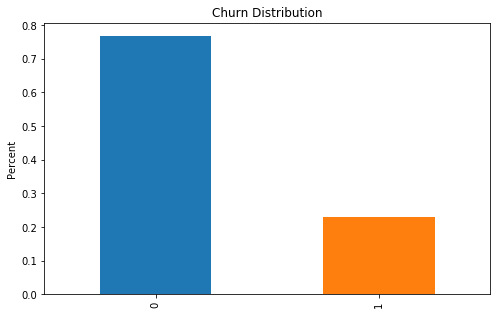

In [126]:
#target measure plots
plt.figure(figsize = (8,5));
pandas_df.label.value_counts(normalize =True).plot(kind ='bar')
plt.ylabel('Percent');
plt.title('Churn Distribution');
plt.savefig('churn.png')

#### Independent Variables

##### Categorical Variables

In [36]:
# gender
pandas_df.female = pandas_df.female.astype('category')

In [47]:
# female have lower churned rate
pandas_df.groupby('label').female.value_counts(normalize =True)

label  female
0      0         0.514451
       1         0.485549
1      0         0.615385
       1         0.384615
Name: female, dtype: float64

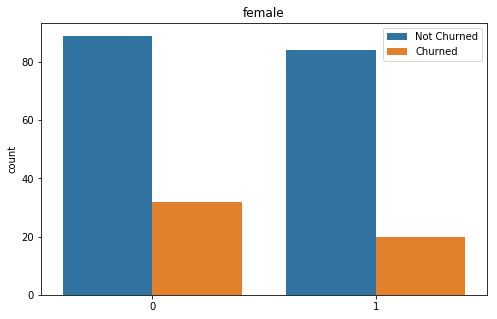

In [124]:
# count plot for gender
plt.figure(figsize = (8,5));
sns.countplot(x='female',hue ='label',data = pandas_df);
plt.legend(['Not Churned', 'Churned']);
plt.title('female');
plt.xlabel("");
plt.savefig('gender.png')

##### Numeric Variables

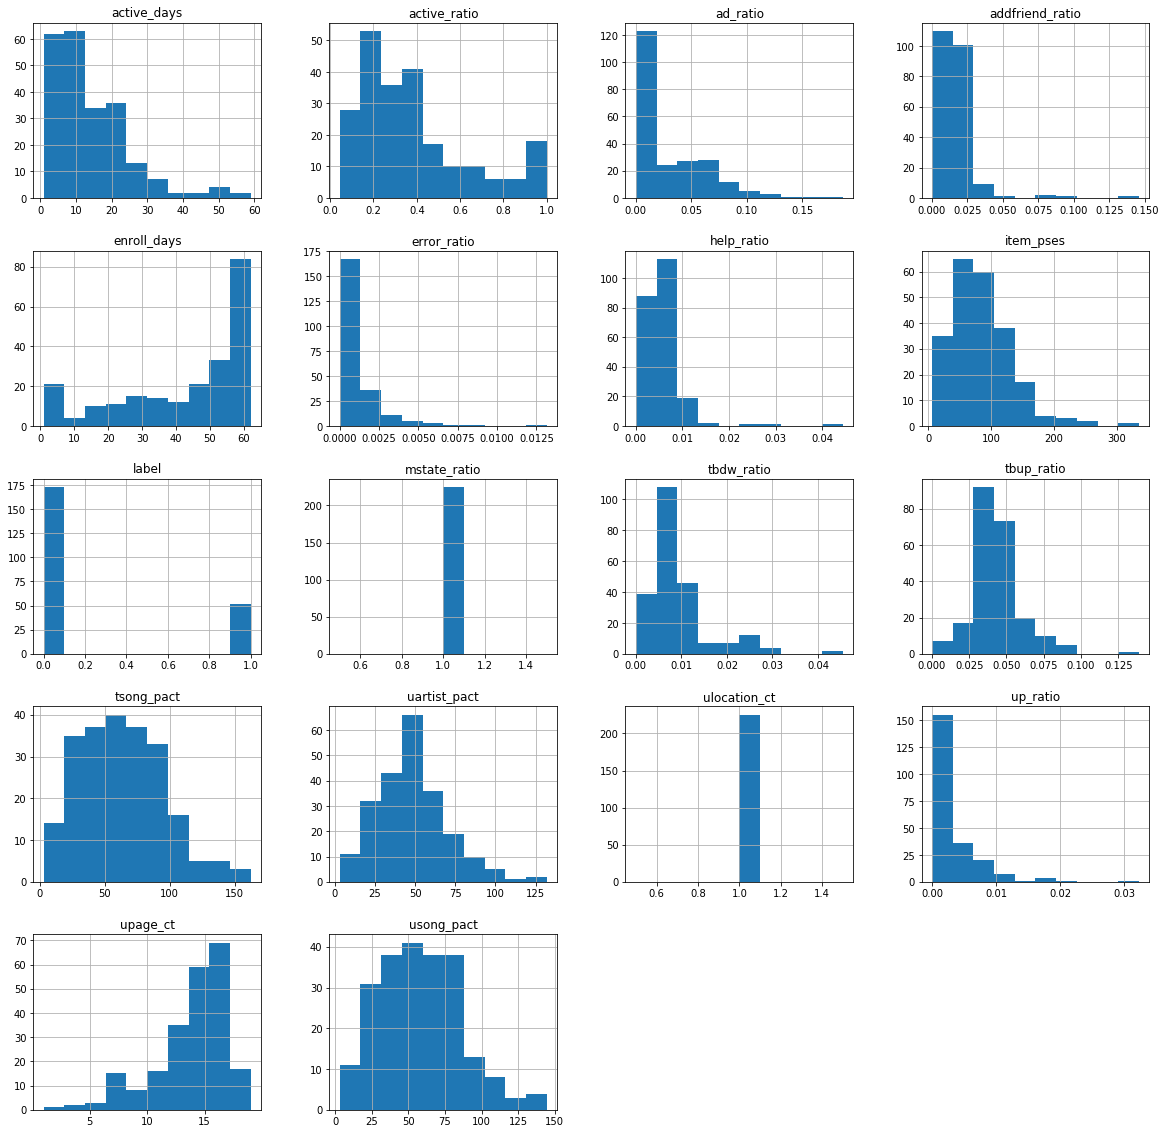

In [37]:
# histogram
pandas_df.hist(figsize = (20,20));

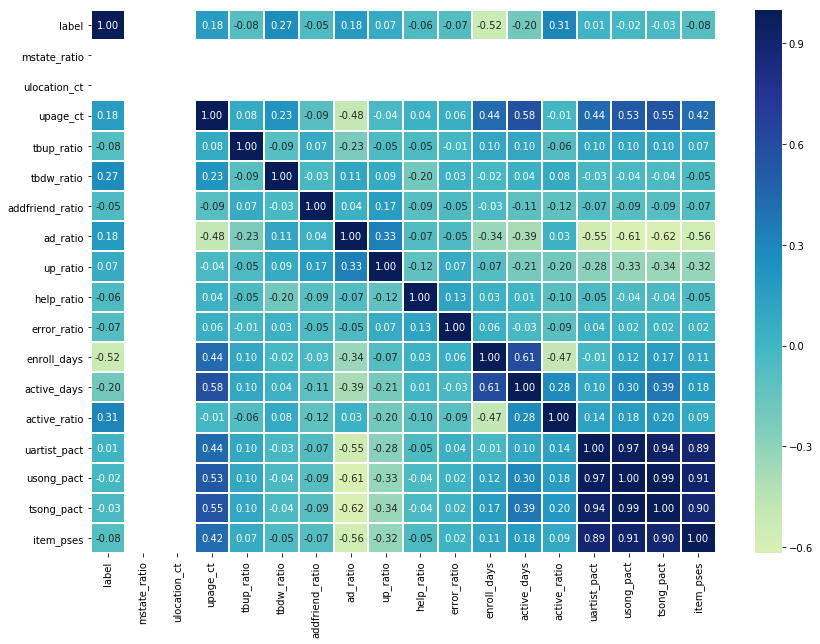

In [18]:
# correlation map
corr = pandas_df.drop('female',axis =1).corr()
plt.figure(figsize = (14,10))
sns.heatmap(corr, cmap ='YlGnBu',center =0, linewidth =1, annot =True, fmt = '.2f');
plt.show()

In [200]:
# Two variables have only one value, uartist_pact, usong_pact, tsong_pact, item_pses are highly correlated.
print(pandas_df.mstate_ratio.value_counts())
print(pandas_df.ulocation_ct.value_counts())

1.0    225
Name: mstate_ratio, dtype: int64
1    225
Name: ulocation_ct, dtype: int64


['mstate_ratio', 'ulocation_ct']

In [128]:
#create drop list
one_value_to_drop = ['mstate_ratio','ulocation_ct']
one_value_to_drop

['mstate_ratio', 'ulocation_ct']

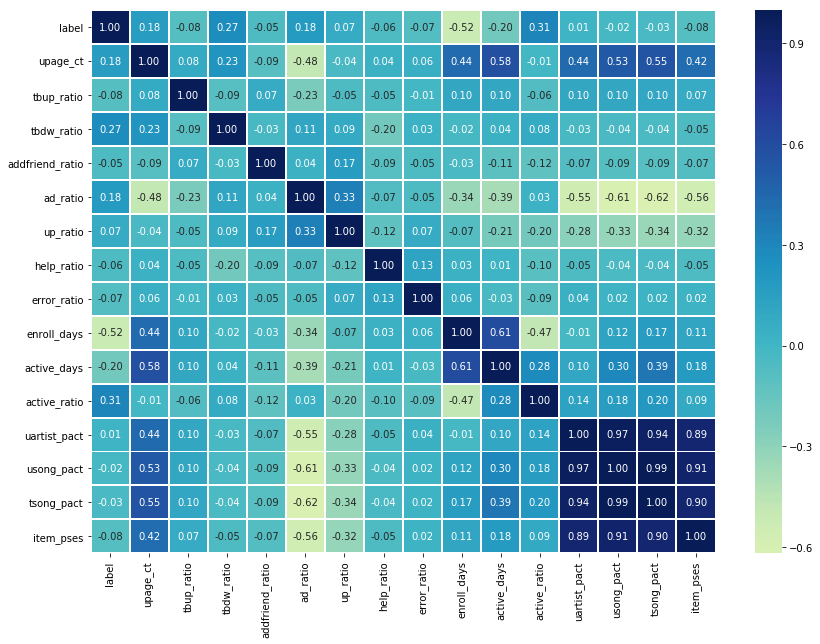

In [131]:
#drop two features
corr = pandas_df.drop(one_value_to_drop,axis =1).corr()
plt.figure(figsize = (14,10))
sns.heatmap(corr, cmap ='YlGnBu',center =0, linewidth =1, annot =True, fmt = '.2f');
plt.show()
plt.savefig('corr_map.png');

In [132]:
# Creating ABS correlation matrix
corr_abs = corr.abs()
# Selecting upper triangle of correlation matrix
upper_tri = corr_abs.where(np.triu(np.ones(corr_abs.shape),k=1).astype(np.bool))
# Finding feature columns with correlation greater than 0.95
high_cor_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
high_cor_to_drop

['usong_pact', 'tsong_pact']

In [15]:
#high_cor_to_drop = ['usong_pact', 'tsong_pact']

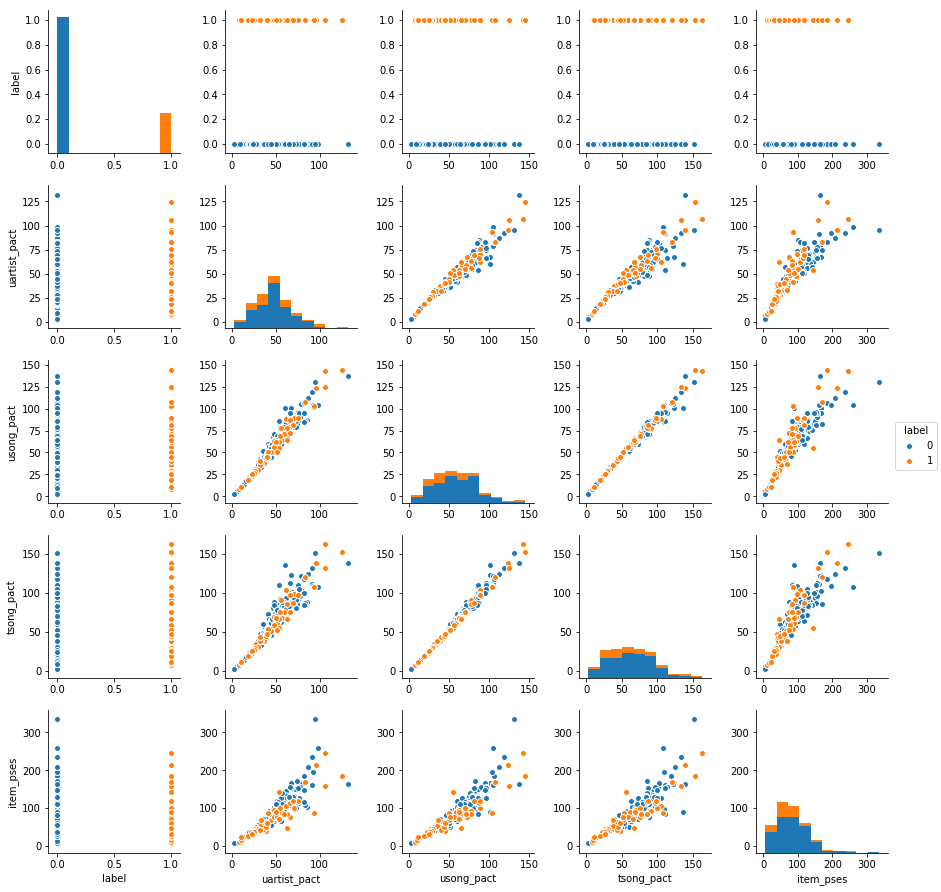

In [64]:
#pair plots for highly correlated features
sns.pairplot(pandas_df[['label','uartist_pact', 'usong_pact', 'tsong_pact', 'item_pses']],hue ='label');

In [119]:
#create density plot function
def density_plot(df,var):
    '''
    INPUT:
    df - pandas dataframe with user data
    var - variable that needs to plot
    
    OUTPUT:
    density plot
    '''
    sns.distplot(df[df['label'] == 0][var], hist = False,  
                kde_kws = {'shade': True},color = 'navy');
    sns.distplot(df[df['label'] == 1][var], hist = False,  
                 kde_kws = {'shade': True}, color = 'orange');
    plt.legend(['Not Churned','Churned']);
    plt.title(var);
    plt.xlabel("");

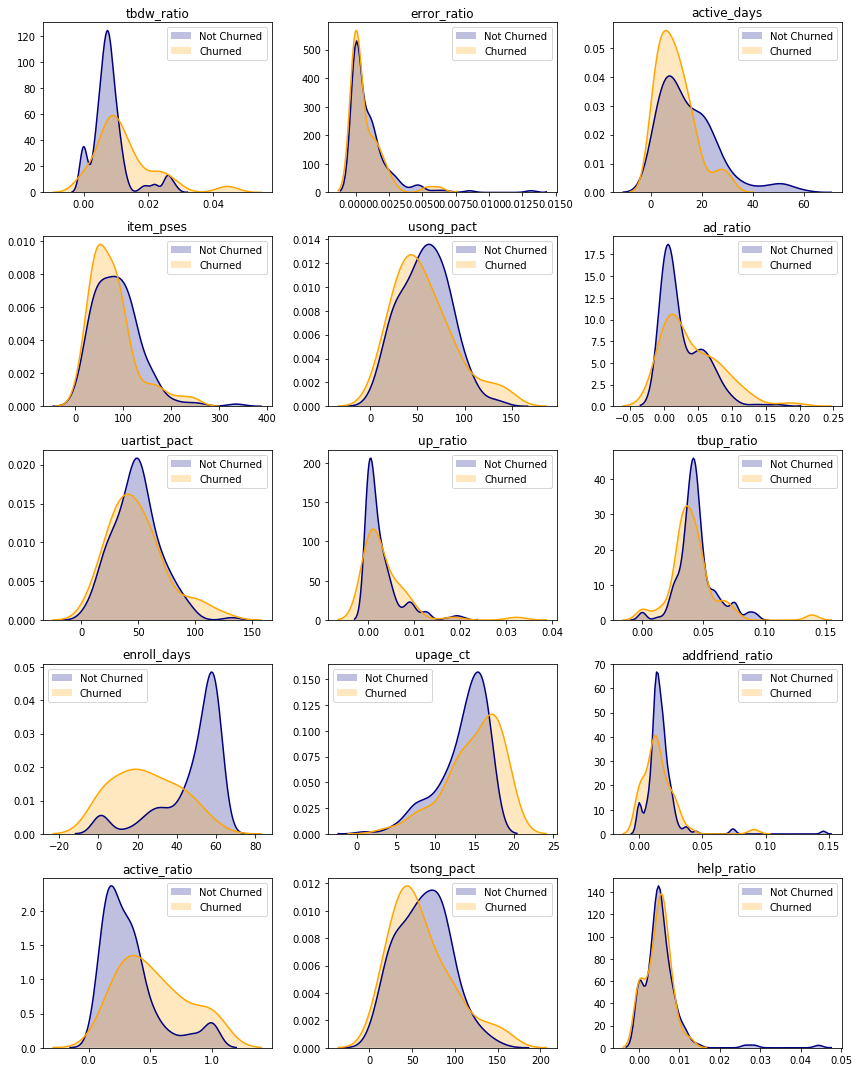

In [123]:
#create density plots
num_col = list(set(pandas_df.columns)-set(['userId','label','female','mstate_ratio','ulocation_ct']))

plt.rcParams['figure.figsize'] = (12,15)
for i in range(len(num_col)):
    plt.subplot(5,3,i+1);
    plt.tight_layout();
    density_plot(pandas_df,num_col[i]);
plt.savefig('density_plots.png')

In [209]:
# Droping Marked Features from one value/high correlated
print(one_value_to_drop)
print(high_cor_to_drop)
pandas_df_clean = pandas_df.drop(one_value_to_drop+high_cor_to_drop, axis=1)

['mstate_ratio', 'ulocation_ct']
['usong_pact', 'tsong_pact']


In [210]:
#check panda data frame
pandas_df_clean.head()

,userId,label,female,upage_ct,tbup_ratio,tbdw_ratio,addfriend_ratio,ad_ratio,up_ratio,help_ratio,error_ratio,enroll_days,active_days,uartist_pact,item_pses
0,100010,0,1,11,0.044619,0.013123,0.010499,0.136483,0.005249,0.005249,0.000000,45,7,36.000000,54.428571
1,200002,0,0,14,0.044304,0.012658,0.008439,0.014768,0.004219,0.004219,0.000000,46,7,48.428571,79.000000
2,125,1,0,4,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,1,1,8.000000,11.000000
3,124,0,1,14,0.035440,0.008497,0.015337,0.000829,0.000000,0.004767,0.001244,61,33,67.636364,166.379310
4,51,1,0,15,0.040584,0.008523,0.011364,0.000000,0.000000,0.004870,0.000406,17,13,106.538462,246.400000


In [135]:
# transfer the drop list to spark data frame
drop_list = one_value_to_drop + high_cor_to_drop
df_user_clean = df_user.select([column for column in df_user.columns if column not in drop_list])

In [24]:
#check spark data frame
df_user_clean.head()

Row(userId='100010', label=0, female=1, upage_ct=11, tbup_ratio=0.04461942257217848, tbdw_ratio=0.013123359580052493, addfriend_ratio=0.010498687664041995, ad_ratio=0.13648293963254593, up_ratio=0.005249343832020997, help_ratio=0.005249343832020997, error_ratio=0.0, enroll_days=45, active_days=7, active_ratio=0.15555555555555556, uartist_pact=36.0, item_pses=54.42857142857143)

# Modelling and Evaluation
This part contains several steps:
1. Split the full dataset into train and test sets. 
2. Build machine learning Pipeline and evaluate the test accuracy of several methods.
3. Conduct 3-fold cross validation and tune parameters. 

I use the F1 score and accuracy as the performance metrics. F1 score is a better choice for the imbalanced data, especially for small subset of data here.
- F1 score: The weighted average of Precision and Recall.
- Accuracy: The measure of all the correctly identified cases.

### Step 1. Split Train (cross-validation) and Test sets

In [136]:
#split the data
train, test = df_user_clean.randomSplit([0.7, 0.3], seed=42)

### Step 2. Build machine learning Pipeline and evaluate the test accuracy of several methods.

In [137]:
#check column list
train.schema.names

['userId',
 'label',
 'female',
 'upage_ct',
 'tbup_ratio',
 'tbdw_ratio',
 'addfriend_ratio',
 'ad_ratio',
 'up_ratio',
 'help_ratio',
 'error_ratio',
 'enroll_days',
 'active_days',
 'active_ratio',
 'uartist_pact',
 'item_pses']

In [138]:
#create initial machine learning pielines
def initial_model(numcols,catcols,classifier = LogisticRegression(maxIter=10),train = train, test = test):
    '''
    INPUT:
    numcols - numerical columns
    catcols - categorical columns (binary)
    classifier - machine learning classifier model
    train - train data
    test - test data
    
    OUTPUT:
    pipeline - machine learning pipeline
    Model - fitted model based on train data
    prediction - predictions on test data
    run time in mins
    '''
    
    start = time.time()
    # Combining into VectorAssembler
    num_assembler = VectorAssembler(inputCols = numcols, outputCol = "num_vector")
    # Standardizing numerical features
    scaler = StandardScaler(inputCol = "num_vector", outputCol = "num_scaled", withStd = True, withMean = True)

    # Add binary feature (do not scale)
    total_assembler = VectorAssembler(inputCols = catcols + ["num_scaled"], outputCol = "features")

    # choose classifiers
    ml =  classifier
    pipeline = Pipeline(stages = [num_assembler, scaler, total_assembler, ml])
    Model = pipeline.fit(train)
    prediction = Model.transform(test) 
    
    end = time.time()
    
    return pipeline,Model, prediction,round(end-start)/60

In [139]:
#evaluation function
def evaluation(prediction):
    '''
    INPUT:
    prediction - predictions on test data
    
    OUTPUT:
    accuracy - metric: (TP + TN)/(TP + TN + FP + FN)
    F1 score - metric: 2 * (Recall * Precision) / (Recall + Precision)
    '''
    
    # Input: model prediction results
    # Output: accuracy and F1 score
       # accuracy: (TP + TN)/(TP + TN + FP + FN)
       # precision: TP/(TP + FP)
       # recall: TP/(TP + FN)
       # f1 score: 2*(Recall * Precision) / (Recall + Precision)
       
    # Combine prediction and labels
    predictionAndLabels = prediction.select(['prediction','label']) \
                      .withColumn("label",col("label").cast(DoubleType())).rdd

    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    
    # Overall statistics
    accuracy = metrics.accuracy
    precision = metrics.precision(label =1.0)
    recall = metrics.recall(label =1.0)
    f1Score = metrics.fMeasure(label =1.0)
    print("Summary Stats")
    print("Accuracy = %s" % accuracy)
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
       
    return round(accuracy,3),round(f1Score,3)

In [140]:
#final features used in the model
numcols = ['upage_ct','tbup_ratio','tbdw_ratio','addfriend_ratio','ad_ratio','up_ratio',
           'help_ratio','error_ratio','enroll_days','active_days','active_ratio','uartist_pact','item_pses']
catcols = ['female']

#### Logistic Regression

In [45]:
# Create logistic regression classifier
pipeline_lr, model_lr, prediction_lr, time_lr = initial_model(numcols,catcols, \
                                                              LogisticRegression(maxIter=10),train, test)
print('Logistic Regression Run time (mins): ',time_lr)
acc_lr, f1_lr = evaluation(prediction_lr)

Logistic Regression Run time (mins):  3.3
Summary Stats
Accuracy = 0.8709677419354839
Precision = 0.9
Recall = 0.5625
F1 Score = 0.6923076923076923


#### Random Forest

In [46]:
# Create Random Forest classifier 
pipeline_rf, model_rf, prediction_rf, time_rf = initial_model(numcols,catcols, \
                                                              RandomForestClassifier(),train, test)
print('Random Forest Run time (mins): ',time_rf)
acc_rf, f1_rf = evaluation(prediction_rf)

Random Forest Run time (mins):  4.35
Summary Stats
Accuracy = 0.8225806451612904
Precision = 0.7777777777777778
Recall = 0.4375
F1 Score = 0.56


#### Gradient-boosted Tree

In [47]:
# Create Gradient-boosted tree classifier 
pipeline_gbt, model_gbt, prediction_gbt, time_gbt = initial_model(numcols,catcols, \
                                                                  GBTClassifier(maxIter=10),train, test)
print('Gradient-boosted Tree Run time (mins): ',time_gbt)
acc_gbt, f1_gbt = evaluation(prediction_gbt)

Gradient-boosted Tree Run time (mins):  5.55
Summary Stats
Accuracy = 0.8548387096774194
Precision = 0.7333333333333333
Recall = 0.6875
F1 Score = 0.7096774193548386


#### Linear Support Vector Machine

In [141]:
# Create Linear Support Vector Machine classifier 
pipeline_svc, model_svc, prediction_svc, time_svc = initial_model(numcols,catcols, \
                                                                  LinearSVC(maxIter=10),train, test)
print('Linear Support Vector Machine Run time (mins): ',time#### Gradient-boosted Tree_svc)
acc_svc, f1_svc = evaluation(prediction_svc)

Linear Support Vector Machine Run time (mins):  5.216666666666667
Summary Stats
Accuracy = 0.8870967741935484
Precision = 1.0
Recall = 0.5625
F1 Score = 0.72


### Step 3. Conduct 3-fold cross validation and tune parameters. 

In [127]:
# tune models
def model_tuning(pipeline,paramGrid,train = train, test = test):
    '''
    INPUT:
    pipeline - machine learning pipeline
    paramGrid - parameter grid for grid search
    train - train data
    test - test data
    
    OUTPUT:
    Model - fitted model based on train data
    prediction - predictions on test data
    run time in mins
    '''
    start = time.time()
    # Combining into VectorAssembler
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)
    cvmodel = crossval.fit(train)
    #predict on test data
    cvprediction = cvmodel.transform(test)
    end = time.time()
    
    return cvmodel, cvprediction,round(end-start)/60

In [147]:
# check grid search results 
def cvmodel_result(cvmodel):
    '''
    INPUT:
    Model - fitted model based on train data
    
    OUTPUT:
    p_df - pandas data frame of grid search results
    '''
    f1 = cvmodel.avgMetrics
    p_df = pd.DataFrame({p.name: v for p, v in param.items()} for param in cvmodel.getEstimatorParamMaps())
    p_df['f1'] = f1
    p_df = p_df.sort_values(by ='f1',ascending =False)
    
    return p_df

In [142]:
#feature importance
def feature_importance(cvmodel,metric):
    '''
    INPUT:
    Model - fitted model based on train data
    
    OUTPUT:
    f_df - pandas data frame of feature metric (importance)
    '''
    f_df = pd.DataFrame()
    feature = catcols + numcols
    f_df['feature'] = feature
    f_df['importance'] = metric 
    f_df = f_df.sort_values(by ='importance',ascending =False)

    return f_df

#### Logistic Regression Tuning
 - regParam (regularization parameter, default=0.0): [0.0, 0.1]
 - threshold (Threshold in binary classification prediction, default = 0.5):[0.5, 0.6]
 - elasticNetParam (the ElasticNet mixing parameter, 0 for L2 penalty, 1 for L1 penalty, default=0.0): [0.0, 0.5]

In [50]:
# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = model_lr.stages[-1].summary
# check the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
bestThreshold

0.592664621501026

In [52]:
# parameter grid: regularization parameter,threshold, the ElasticNet mixing parameter.
paramGrid_lr = ParamGridBuilder() \
    .addGrid(model_lr.stages[-1].regParam,[0.0,0.1]) \
    .addGrid(model_lr.stages[-1].threshold,[0.5,0.6]) \
    .addGrid(model_lr.stages[-1].elasticNetParam, [0.0,0.5]) \
    .build()

In [53]:
# tune the model
cvmodel_lr, cvprediction_lr, cvtime_lr = model_tuning(pipeline_lr,paramGrid_lr,train, test)
print('Logistic Regression Model Tuning time (mins): ',cvtime_lr)
cvacc_lr, cvf1_lr = evaluation(cvprediction_lr)

Logistic Regression Model Tuning time (mins):  19.9
Summary Stats
Accuracy = 0.8709677419354839
Precision = 0.9
Recall = 0.5625
F1 Score = 0.6923076923076923


In [148]:
# training model results
cvmodel_result(cvmodel_lr)

,elasticNetParam,regParam,threshold,f1
0,0.0,0.0,0.5,0.912848
1,0.5,0.0,0.5,0.912848
2,0.0,0.0,0.6,0.912848
3,0.5,0.0,0.6,0.912848
4,0.0,0.1,0.5,0.912848
5,0.5,0.1,0.5,0.912848
6,0.0,0.1,0.6,0.912848
7,0.5,0.1,0.6,0.912848


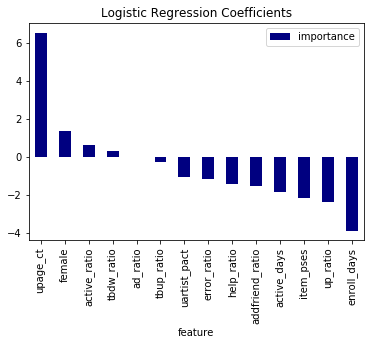

In [104]:
# Coefficients
lr_imp = feature_importance(cvmodel_lr,cvmodel_lr.bestModel.stages[-1].coefficients)
lr_imp['odds'] = np.exp(lr_imp['importance'])
lr_imp.plot(kind ='bar',x ='feature',y='importance',color ='navy',\
            title = 'Logistic Regression Coefficients');

#### Gradient-boosted Tree Tuning
 - maxDepth (Maximum depth of the tree, default=5): [5, 10]
 - minInstancesPerNode (Minimum number of instances each child must have after split, default=1): [1,3]

In [59]:
# parameter grid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(model_gbt.stages[-1].maxDepth, [5, 10]) \
    .addGrid(model_gbt.stages[-1].minInstancesPerNode,[1,3]) \
    .build()

In [60]:
# tune the model
cvmodel_gbt, cvprediction_gbt, cvtime_gbt = model_tuning(pipeline_gbt,paramGrid_gbt,train, test)
print('Gradient-boosted Tree Model Tuning time (mins): ',cvtime_gbt)
cvacc_gbt, cvf1_gbt = evaluation(cvprediction_gbt)

Gradient-boosted Tree Model Tuning time (mins):  49.85
Summary Stats
Accuracy = 0.8548387096774194
Precision = 0.7333333333333333
Recall = 0.6875
F1 Score = 0.7096774193548386


In [149]:
# training model results
cvmodel_result(cvmodel_gbt)

,maxDepth,minInstancesPerNode,f1
3,10,3,0.834527
0,5,1,0.833799
2,10,1,0.828218
1,5,3,0.826676


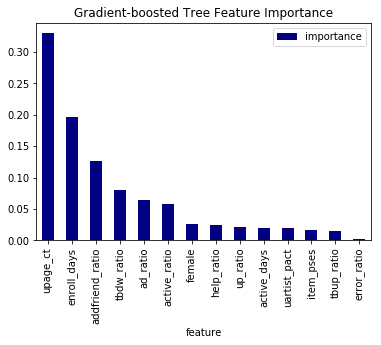

In [101]:
#show feature importances
feature_importance(cvmodel_gbt,cvmodel_gbt.bestModel.stages[-1].featureImportances) \
.plot(kind ='bar',x ='feature',y='importance',color ='navy', \
      title = 'Gradient-boosted Tree Feature Importance');

#### Linear Support Vector Machine Tuning
 - maxIter (maximum number of iterations, default=100): [10, 20]
 - threshold (Threshold in binary classification prediction, default = 0.0):[0.5, 0.6]

In [114]:
# parameter grid
paramGrid_svc = ParamGridBuilder() \
    .addGrid(model_svc.stages[-1].maxIter, [10, 20]) \
    .addGrid(model_svc.stages[-1].threshold,[0.5,0.6]) \
    .build()

In [115]:
# tune the model
cvmodel_svc, cvprediction_svc, cvtime_svc = model_tuning(pipeline_svc,paramGrid_svc,train, test)
print('Gradient-boosted Tree Model Tuning time (mins): ',cvtime_svc)
cvacc_svc, cvf1_svc = evaluation(cvprediction_svc)

Gradient-boosted Tree Model Tuning time (mins):  27.15
Summary Stats
Accuracy = 0.8870967741935484
Precision = 1.0
Recall = 0.5625
F1 Score = 0.72


In [150]:
# training model results
cvmodel_result(cvmodel_svc)

,maxIter,threshold,f1
2,20,0.5,0.856189
3,20,0.6,0.856189
1,10,0.6,0.850617
0,10,0.5,0.845036


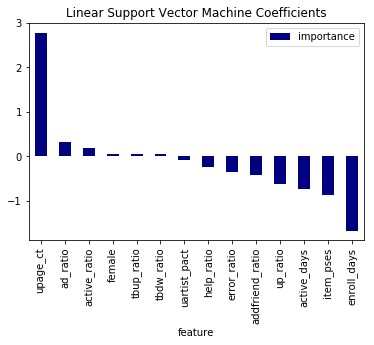

In [121]:
#show feature importances
feature_importance(cvmodel_svc,cvmodel_svc.bestModel.stages[-1].coefficients) \
.plot(kind ='bar',x ='feature',y='importance',color ='navy', \
      title = 'Linear Support Vector Machine Coefficients');

In [ ]:
### Random Forest 
# parameter grid
paramGrid_rf = ParamGridBuilder() \
    .addGrid(model_rf.stages[-1].minInstancesPerNode,[1,3]) \
    .addGrid(model_rf.stages[-1].numTrees, [20, 30]) \
    .build()
    
# tune the model
cvmodel_rf, cvprediction_rf, cvtime_rf = model_tuning(pipeline_rf,paramGrid_rf,train, test)
print('Random Forest Model Tuning time (mins): ',cvtime_rf)
cvacc_rf, cvf1_rf = evaluation(cvprediction_rf)    

# model results
print(cvmodel_result(cvmodel_rf))

#show feature importances
feature_importance(cvmodel_rf,cvmodel_rf.bestModel.stages[-1].featureImportances) \
.plot(kind ='bar',x ='feature',y='importance',color ='navy', \
      title = 'Random Forest Feature Importance');

### Performance Summary
Linear Support Vector Machine and Gradient-boosted tree classifier have higher F1 Score on test data. Linear Support Vector Machine and Logistic Regression have higher accuracy on test data.